# Switching Linear Dynamical System

In this notebook, we implement a hierarchical state-space model: the switching linear dynamical system (SLDS). These models are useful for modeling time-series that 1.) experience abrupt changes in the underlying dynamics or 2.) are nonlinear, but can be described as being roughly piecewise linear. These models have an intractable posterior distribution, and so we make use of a Variational EM approach. For a discussion on our current VI approach refer to: *Variational Learning for Switching State-Space Models* by Zhoubin Gharamani and Geoffrey Hinton. In this specific example, we will assume both a Gaussian state and observation model.

## Setup

In [1]:
# import the relevant packages
using StateSpaceDynamics
using LinearAlgebra
using Random
using Plots
using LaTeXStrings
using Statistics


## Simulate Data from an SLDS

In [2]:
using StateSpaceDynamics: LinearDynamicalSystem, GaussianStateModel, GaussianObservationModel

state_dim = 2
obs_dim = 10
K = 2 # two states

# Create the HMM parameters
A_hmm = [0.92 0.08; 0.06 0.94]
π₀ = [1.0, 0.0]

# Create the state models
A₁ = 0.95 * [cos(0.05) -sin(0.05); sin(0.05) cos(0.05)] # slower oscillator
A₂ = 0.95 * [cos(0.55) -sin(0.55); sin(0.55) cos(0.55)] # faster oscillator

Q₁ = [0.001 0.0; 0.0 0.001]
Q₂ = [0.1 0.0; 0.0 0.1]

# Assume same initial distribution for ease
x0 = [0.0, 0.0]
P0 = [0.1 0.0; 0.0 0.1]

# create the observation models
C₁ = randn(obs_dim, state_dim)
C₂ = randn(obs_dim, state_dim)

R = Matrix(0.1 * I(obs_dim)) # Assume same noise covariance for both states

# Put it all together for an SLDS model
model = SwitchingLinearDynamicalSystem(
    A_hmm,
    [LinearDynamicalSystem(GaussianStateModel(A₁, Q₁, x0, P0), GaussianObservationModel(C₁, R), state_dim, obs_dim, fill(true, 6)), 
     LinearDynamicalSystem(GaussianStateModel(A₂, Q₂, x0, P0), GaussianObservationModel(C₂, R), state_dim, obs_dim, fill(true, 6))],
     π₀,
    K)



SwitchingLinearDynamicalSystem([0.92 0.08; 0.06 0.94], LinearDynamicalSystem[LinearDynamicalSystem{GaussianStateModel{Float64}, GaussianObservationModel{Float64}}(GaussianStateModel{Float64}([0.9488127473752179 -0.04748021080714441; 0.04748021080714441 0.9488127473752179], [0.001 0.0; 0.0 0.001], [0.0, 0.0], [0.1 0.0; 0.0 0.1]), GaussianObservationModel{Float64}([0.05637891660087352 0.8340945713226584; 1.1408682325438155 0.1406209715570708; … ; 0.6850335101799919 -0.09850079148761075; 0.6725295298040477 1.4887829265878836], [0.1 0.0 … 0.0 0.0; 0.0 0.1 … 0.0 0.0; … ; 0.0 0.0 … 0.1 0.0; 0.0 0.0 … 0.0 0.1]), 2, 10, Bool[1, 1, 1, 1, 1, 1]), LinearDynamicalSystem{GaussianStateModel{Float64}, GaussianObservationModel{Float64}}(GaussianStateModel{Float64}([0.8098982959565304 -0.49655286748412625; 0.49655286748412625 0.8098982959565304], [0.1 0.0; 0.0 0.1], [0.0, 0.0], [0.1 0.0; 0.0 0.1]), GaussianObservationModel{Float64}([-0.8126744277139875 3.379485440767245; -0.8378683142942338 0.533102586

In [3]:
T = 1000
# Generate synthetic data
x, y, z = StateSpaceDynamics.sample(model, T)

([-0.018679912520258166 0.0014606468151764918 … -0.36624386708049933 -0.35008148791278143; 0.03142005862189728 0.046742376619618206 … -0.35420859064342736 -0.647441285270187], [0.1058264490523371 0.14060925982097608 … -0.7936057744252267 -2.2882100779989147; -0.2990892866317144 -0.09512973360620744 … -0.02346929001007994 -0.2779508430318147; … ; -0.0984088470390305 -0.07926731079614682 … 0.5700267544450295 0.0774791888366666; 0.477071861717534 -0.011439955658509082 … 0.17548311275084824 -0.6078813333241594], [1, 1, 1, 1, 2, 2, 2, 2, 2, 2  …  2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

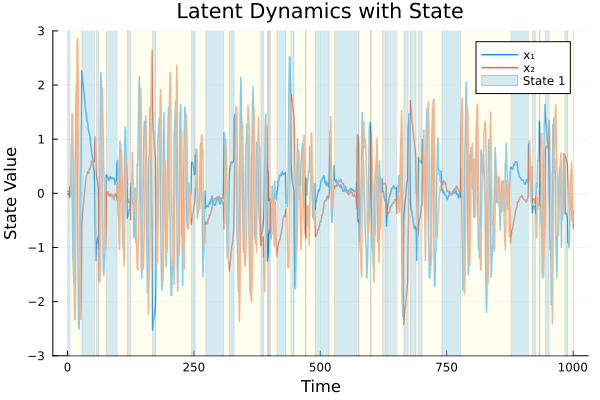

In [4]:
# Assuming x, y, z are already defined from previous code
plot(1:T, x[1, :], label="x₁",  linewidth=1.5)
plot!(1:T, x[2, :], label="x₂", linewidth=1.5)

# Create a background shading based on the state (z)
vspan_indices = findall(diff(z) .!= 0)
push!(vspan_indices, T)  # Add the end of the series
start_idx = 1
current_state = z[1]

for end_idx in vspan_indices
    # Choose color based on state value
    bg_color = current_state == 1 ? :lightblue : :lightyellow
    
    # Add a background shading for this state region
    vspan!([start_idx, end_idx], fillalpha=0.5, color=bg_color, 
           label=(start_idx == 1 ? "State $current_state" : ""))
    
    # Prepare for next region
    if end_idx < T
        start_idx = end_idx + 1
        current_state = z[start_idx]
    end
end

# Adjust the plot appearance
title!("Latent Dynamics with State")
xlabel!("Time")
ylabel!("State Value")
ylims!(-3, 3)


## Fit an SLDS model to the data

In [5]:
# Create a model to start with for EM, using reasonable guesses
A = [0.9 0.1; 0.1 0.9]
A ./= sum(A, dims=2) # Normalize rows to sum to 1

πₖ = rand(K)
πₖ ./= sum(πₖ) # Normalize to sum to 1

Q = Matrix(0.001 * I(state_dim))

x0 = [0.0; 0.0]
P0 = Matrix(0.001 * I(state_dim))

# set up the observation parameters
C = randn(obs_dim, state_dim)
R = Matrix(0.1 * I(obs_dim))

B = [StateSpaceDynamics.LinearDynamicalSystem(
    StateSpaceDynamics.GaussianStateModel(0.95 * [cos(f) -sin(f); sin(f) cos(f)], Q, x0, P0),
    StateSpaceDynamics.GaussianObservationModel(C, R),
    state_dim, obs_dim, fill(true, 6)) for (i,f) in zip(1:K, [0.7, 0.1])]

learned_model = SwitchingLinearDynamicalSystem(A, B, πₖ, model.K)

SwitchingLinearDynamicalSystem([0.9 0.1; 0.1 0.9], LinearDynamicalSystem[LinearDynamicalSystem{GaussianStateModel{Float64}, GaussianObservationModel{Float64}}(GaussianStateModel{Float64}([0.726600077920264 -0.6120068028758064; 0.6120068028758064 0.726600077920264], [0.001 0.0; 0.0 0.001], [0.0, 0.0], [0.001 0.0; 0.0 0.001]), GaussianObservationModel{Float64}([0.010669947107097764 -0.5183972719723805; 0.9524298066599248 -1.3112490105261374; … ; 0.9808434923096931 -0.7240101706602943; 0.9213763798015127 -0.563351939566375], [0.1 0.0 … 0.0 0.0; 0.0 0.1 … 0.0 0.0; … ; 0.0 0.0 … 0.1 0.0; 0.0 0.0 … 0.0 0.1]), 2, 10, Bool[1, 1, 1, 1, 1, 1]), LinearDynamicalSystem{GaussianStateModel{Float64}, GaussianObservationModel{Float64}}(GaussianStateModel{Float64}([0.9452539570141245 -0.09484174581448675; 0.09484174581448675 0.9452539570141245], [0.001 0.0; 0.0 0.001], [0.0, 0.0], [0.001 0.0; 0.0 0.001]), GaussianObservationModel{Float64}([0.010669947107097764 -0.5183972719723805; 0.9524298066599248 -1.

In [6]:
mls, param_diff, FB, FS = fit!(learned_model, y; max_iter=25) # use 25 iterations of EM

Fitting SLDS via vEM... 100%|██████████████████████████████████████████████████| Time: 0:02:30 ( 6.03  s/it)


([-188900.4159564413, -39956.05093701626, -28484.33738891106, -26743.55618684167, -25434.528879733498, -23970.425077715998, -22218.571269932014, -21187.370135391313, -20546.911812532653, -20455.153390419095  …  -20421.08323156681, -20420.946944693897, -20421.015365858613, -20421.187817555052, -20421.40399606282, -20421.6290801169, -20421.84417840501, -20422.040407046767, -20392.871771148923, -20392.86013895101], [14.855727064148201, 2.9998293691612195, 0.9596103116073772, 1.133829708260639, 1.783213748086263, 2.153850530261121, 2.080131164693133, 1.1893234807907986, 0.7702127404286181, 0.2742812171525201  …  0.028499855359837126, 0.022840960937754843, 0.01831709814717965, 0.014690231010399778, 0.011780233920108366, 0.009445881569436964, 0.0075746528099244585, 0.00607693396720426, 0.024239979808193673, 0.005454689383033865], StateSpaceDynamics.ForwardBackward{Float64}([-3.252074599989588 -16.70413224974367 … -3.0803851992164426 -3.707680146177783; -2.6100967593452955 -1.398420480509002 

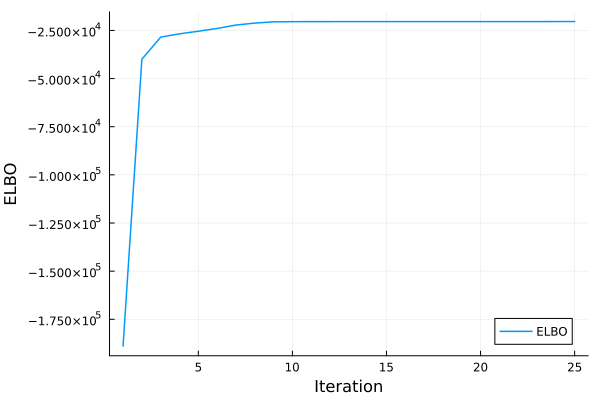

In [7]:
plot(mls, label="ELBO", linewidth=1.5)
xlabel!("Iteration")
ylabel!("ELBO")

## Compare the true and learned model

In [8]:
# Plot the latent states as a weighted function of the responsibilities for each state

latents = zeros(state_dim, T)  # Initialize with state dimension, not K
resp = exp.(FB.γ)  # Responsibilities (probabilities) for each state at each time

# For each time point, compute the weighted average of the smoothed states
for t in 1:T
    for k in 1:K
        latents[:, t] += FS[k].x_smooth[:, t] .* resp[k, t]
    end
end

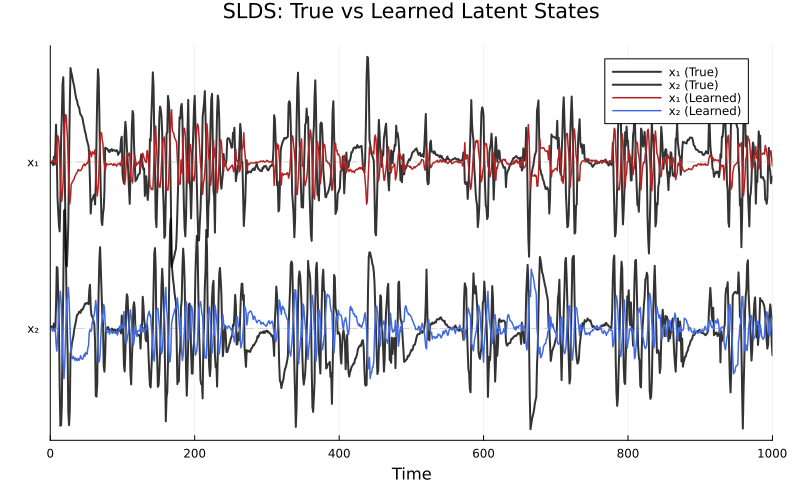

In [9]:
# Plot the learned latent states on top of the original with improved styling
plt = plot(size=(800, 500), background_color=:white, margin=5Plots.mm)

# Plot true values
plot!(x[1, :] .+ 2, label="x₁ (True)", linewidth=2, color=:black, alpha=0.8)
plot!(x[2, :] .- 2, label="x₂ (True)", linewidth=2, color=:black, alpha=0.8)

# Plot learned values
plot!(latents[1, :] .+ 2, label="x₁ (Learned)", linewidth=1.5, color=:firebrick)
plot!(latents[2, :] .- 2, label="x₂ (Learned)", linewidth=1.5, color=:royalblue)

# Improve styling
title!("SLDS: True vs Learned Latent States")
xlabel!("Time")
ylabel!("")  # Remove the default y label

# Custom y-ticks with state labels at the correct positions
yticks!([-2, 2], ["x₂", "x₁"])  # Set custom tick positions and labels

# Add horizontal lines to emphasize the state positions
hline!([2], color=:gray, alpha=0.3, linestyle=:dash, label="")
hline!([-2], color=:gray, alpha=0.3, linestyle=:dash, label="")

xlims!(0, T)